In [23]:
!pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\lenovo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [31]:

columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
           'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime',
           'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
           'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


movies = pd.read_csv(r"C:\Users\lenovo\Downloads\archive\ml-100k\u.item", sep='|', encoding='latin-1', names=columns)
movies.head()


,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [32]:
genre_cols = columns[5:]  # From 'unknown' to 'Western'
# Create a string of genres for each movie
movies['genre'] = movies[genre_cols].apply(lambda row: ' '.join([genre for genre, val in row.items() if val == 1]), axis=1)


In [33]:
movies = movies[['movie_id', 'title', 'release_date', 'genre']]

# Drop nulls and convert release_date
movies.dropna(subset=['release_date'], inplace=True)
movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')
movies['year'] = movies['release_date'].dt.year

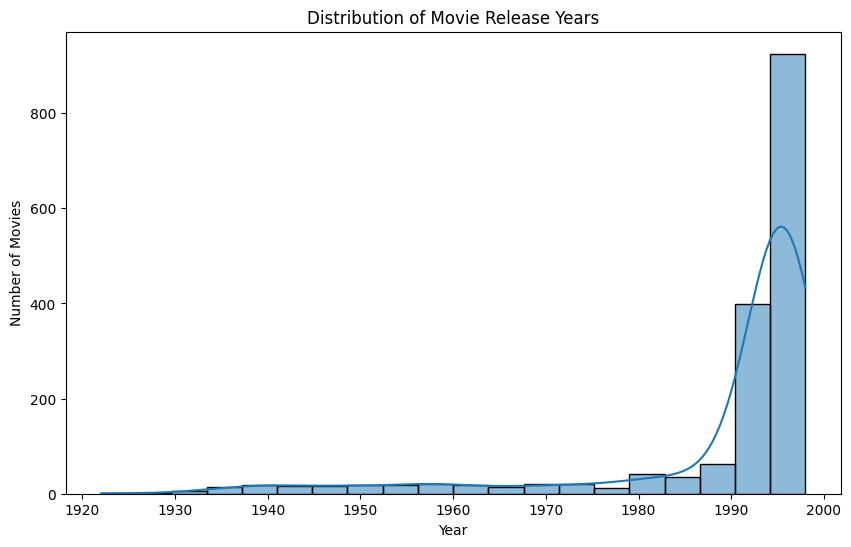

In [34]:
plt.figure(figsize=(10,6))
sns.histplot(movies['year'].dropna(), bins=20, kde=True)
plt.title('Distribution of Movie Release Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()

In [35]:
movies['Bag of words'] = movies['title'] + ' ' + movies['genre']

# TF-IDF
vector_tfidf = TfidfVectorizer(stop_words='english').fit_transform(movies['Bag of words']).toarray()

# Cosine similarity
similarity_Tfidf = cosine_similarity(vector_tfidf)

In [46]:
def preprocess_title(title):
    title = re.sub(r'[.,]', '', title)
    title = title.strip().lower()
    return title

def recommand_Tfidf(movie_title):
    processed_title = preprocess_title(movie_title)
    movies['processed_title'] = movies['title'].apply(preprocess_title)

    matched = movies[movies['processed_title'] == processed_title]
    if matched.empty:
        print(f"Movie '{movie_title}' not found.")
        return
    
    index = matched.index[0]
    distance = sorted(
        [(i, sim) for i, sim in enumerate(similarity_Tfidf[index]) if i != index],
        reverse=True,
        key=lambda x: x[1]
    )

    print(f"Top 10 movies similar to '{movie_title}':")
    for i in distance[:10]:
        print(movies.iloc[i[0]].title)
        


In [53]:
recommand_Tfidf("four rooms (1995)")



Top 10 movies similar to 'four rooms (1995)':
Other Voices, Other Rooms (1997)
Now and Then (1995)
To Have, or Not (1995)
Murder in the First (1995)
Safe (1995)
Jade (1995)
Assassins (1995)
Hideaway (1995)
Last Supper, The (1995)
Babysitter, The (1995)


In [51]:
import pickle
pickle.dump(movies, open('movies_list.pkl', 'wb'))
pickle.dump(similarity_Tfidf, open('similarity_Tfidf.pkl', 'wb'))
